[Epoch 1/10] Loss: 2.0594


[Epoch 2/10] Loss: 1.6394


[Epoch 3/10] Loss: 1.4784


[Epoch 4/10] Loss: 1.4474


[Epoch 5/10] Loss: 1.3725


[Epoch 6/10] Loss: 1.3714


[Epoch 7/10] Loss: 1.3029


[Epoch 8/10] Loss: 1.2413


[Epoch 9/10] Loss: 1.2766


[Epoch 10/10] Loss: 1.2391
Training complete!


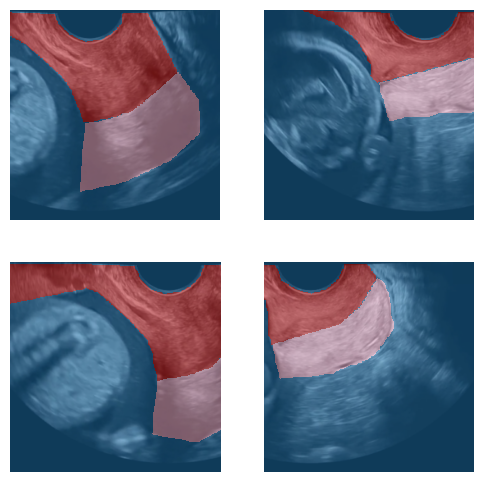

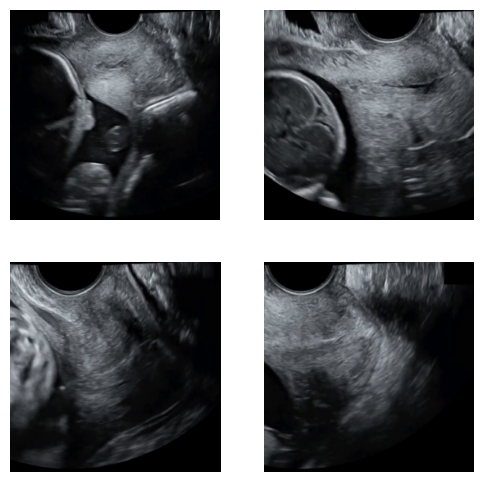

In [1]:
from fastai.vision.all import *
import fastcore.all as fc
import torch.optim as optim

# Define the root directory for the dataset
dataroot_dir = Path('dataset')

# Define labeled and unlabeled directories based on dataroot
labeled_dataroot_dir = dataroot_dir/'labeled_data'
unlabeled_dataroot_dir = dataroot_dir/'unlabeled_data'

dataroot_dir.ls(), labeled_dataroot_dir.ls(), unlabeled_dataroot_dir.ls()

# Define class codes for segmentation
class_codes = ['background', 'anterior', 'posterior']  # Ensure correct class mappings

# Image and mask transformations
item_tfms = [Resize((256, 256), method='nearest')]  # Resize masks with nearest neighbor
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

# Function to get the mask path from the image path
def get_y(image_path):
    return Path(str(image_path).replace("images", "labels"))

# Labeled DataBlock (Multi-class Segmentation)
labeled_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_codes)),  # Multi-class segmentation
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,  # Map image path to corresponding mask
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create labeled DataLoaders
labeled_dls = labeled_block.dataloaders(labeled_dataroot_dir/'images', bs=4, shuffle=True, num_workers=0)

labeled_dls.show_batch()

# Unlabeled DataBlock (for inference)
unlabeled_block = DataBlock(
    blocks=(ImageBlock,),  # Only images, no labels
    get_items=get_image_files,
    splitter=None,  # No splitting needed
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create unlabeled DataLoaders
unlabeled_dls = unlabeled_block.dataloaders(unlabeled_dataroot_dir/'images', bs=4, shuffle=True)

unlabeled_dls.show_batch()

# ✅ Activation Function
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x): 
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

act_gr = lambda: GeneralRelu(leak=0.1, sub=0.4)

# ✅ Convolution Block
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

# ✅ Residual Block
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = nn.Sequential(
            conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
            conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))
        self.idconv = nn.Identity() if ni == nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = nn.Identity() if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): 
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

# ✅ Tiny UNet Model
class TinyUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(in_channels, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([conv(nfs[i], nfs[i-1], ks=3, stride=1, act=act, norm=norm) for i in range(len(nfs)-1,0,-1)])
        self.seg_head = nn.Conv2d(nfs[0], out_channels, kernel_size=1)

    def forward(self, x):
        layers = [self.start(x)]
        for l in self.dn: layers.append(l(layers[-1]))

        x = layers[-1]
        for i, l in enumerate(self.up, 1):
            upsampled_x = F.interpolate(l(x), size=layers[-i-1].shape[2:], mode="bilinear", align_corners=False)
            # print(f"🟢 Up Block {i}: upsampled_x shape={upsampled_x.shape}, Skip Connection shape={layers[-i-1].shape}")
            x = upsampled_x + layers[-i-1]  # ✅ Ensure matching dimensions

        return self.seg_head(x)

# ✅ Teacher-Student Model
class UltraSemiNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, alpha=0.99):
        super(UltraSemiNet, self).__init__()
        self.student_net = TinyUnet(in_channels=in_channels, out_channels=num_classes)
        self.teacher_net = TinyUnet(in_channels=in_channels, out_channels=num_classes)
        self._update_teacher(0.0)
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, x):
        return self.student_net(x)

    @torch.no_grad()
    def _update_teacher(self, alpha=None):
        if alpha is None: alpha = self.alpha
        for teacher_param, student_param in zip(self.teacher_net.parameters(), self.student_net.parameters()):
            teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data

# ✅ Loss Functions
def compute_hardness_map(logits):
    probs = torch.softmax(logits, dim=1)
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=1, keepdim=True)

def semi_supervised_loss(student_logits, teacher_logits, labels, mask, temperature):
    # print(f"🔍 semi_supervised_loss: student_logits.shape={student_logits.shape}, labels.shape={labels.shape}")
    return CrossEntropyLossFlat()(student_logits, labels)

# ✅ Teacher-Student Training
class UltraSemiNetLearner(Learner):
    def __init__(self, student_teacher_model, labeled_dls, unlabeled_dls, optimizer, num_epochs=10, temperature=0.07, save_path="model.pth"):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.student_model = student_teacher_model.student_net.to(device)
        self.teacher_model = student_teacher_model.teacher_net.to(device)
        self.labeled_dls = labeled_dls
        self.unlabeled_dls = unlabeled_dls
        self.train_dl = self.labeled_dls.train
        self.valid_dl = self.labeled_dls.valid
        self.unlabeled_dl = self.unlabeled_dls.train
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.temperature = temperature
        self.save_path = save_path
        self.best_loss = float("inf")

        # ✅ Define `loss_func`
        self.loss_func = self.compute_loss

        # ✅ Initialize Learner correctly
        super().__init__(self.student_model, self.labeled_dls, opt_func=lambda: self.optimizer, loss_func=self.loss_func)

    def compute_loss(self, student_logits, teacher_logits, labels, mask):
        """ Loss function for UltraSemiNet """
        # print(f"\n🔍 compute_loss: student_logits.shape={student_logits.shape}, labels.shape={labels.shape}")

        # ✅ Correct Reshaping for Loss
        student_logits = student_logits.permute(0, 2, 3, 1).reshape(-1, student_logits.shape[1])
        labels = labels.view(-1)

        return semi_supervised_loss(student_logits, teacher_logits, labels, mask, self.temperature)

    def train(self):
        device = next(self.student_model.parameters()).device

        for epoch in range(self.num_epochs):
            self.student_model.train()
            self.teacher_model.eval()

            running_loss = 0.0
            steps = 0

            pbar = progress_bar(zip(iter(self.train_dl), iter(self.unlabeled_dl)), total=min(len(self.train_dl), len(self.unlabeled_dl)))

            for (x_l, y_l), (x_u,) in pbar:
                x_l, y_l = x_l.to(device), y_l.to(device)
                x_u = x_u.to(device)

                # **Forward Pass (Supervised)**
                logits_l = self.student_model(x_l)

                # ✅ Ensure label is in correct shape before loss
                y_l = y_l.view(logits_l.shape[0], logits_l.shape[2], logits_l.shape[3])

                # ✅ Reshape for Loss Function
                logits_l = logits_l.permute(0, 2, 3, 1).reshape(-1, logits_l.shape[1])  # (B*H*W, num_classes)
                y_l = y_l.view(-1)  # (B*H*W,)

                # ✅ Compute Supervised Loss
                supervised_loss = CrossEntropyLossFlat()(logits_l, y_l)

                # **Forward Pass (Unsupervised - Teacher)**
                with torch.no_grad():
                    logits_u_teacher = self.teacher_model(x_u)

                logits_u_student = self.student_model(x_u)
                hardness_mask = compute_hardness_map(logits_u_teacher)

                # **Total Loss**
                total_loss = supervised_loss + self.loss_func(logits_u_student, logits_u_teacher, y_l, hardness_mask)

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                running_loss += total_loss.item()
                steps += 1

                # ✅ Update Progress Bar
                pbar.comment = f"Loss: {total_loss.item():.4f}"

            epoch_loss = running_loss / steps if steps > 0 else 0.0
            print(f"[Epoch {epoch+1}/{self.num_epochs}] Loss: {epoch_loss:.4f}")

            if epoch_loss < self.best_loss:
                self.best_loss = epoch_loss
                torch.save(self.student_model.state_dict(), self.save_path)

        print("Training complete!")

# ✅ Train the Model
model = UltraSemiNet(in_channels=3, num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
learner = UltraSemiNetLearner(model, labeled_dls, unlabeled_dls, optimizer, num_epochs=10)
learner.train()